<a href="https://colab.research.google.com/github/KeyGoddle/SARAEV_PRAK/blob/main/Kohhen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("valakhorasani/bank-transaction-dataset-for-fraud-detection")

print("Path to dataset files:", path)
import pandas as pd
df = pd.read_csv('/root/.cache/kagglehub/datasets/valakhorasani/bank-transaction-dataset-for-fraud-detection/versions/4/bank_transactions_data_2.csv')
df.head()

Path to dataset files: /root/.cache/kagglehub/datasets/valakhorasani/bank-transaction-dataset-for-fraud-detection/versions/4


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Загружаем данные
data = pd.read_csv('/root/.cache/kagglehub/datasets/valakhorasani/bank-transaction-dataset-for-fraud-detection/versions/4/bank_transactions_data_2.csv')

# Проверяем типы данных
print(data.info())

# Перевод категориальных данных в числовые
for col in data.select_dtypes(include='object').columns:
    data[col] = LabelEncoder().fit_transform(data[col])

# Заполняем пропущенные значения средними
data = data.fillna(data.mean())

# Нормализация данных
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

In [ ]:
class KohonenSOM:
    def __init__(self, input_dim, output_neurons, learning_rate):
        self.weights = np.random.rand(output_neurons, input_dim)
        self.weights = self.weights / np.linalg.norm(self.weights, axis=1, keepdims=True)
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate

    def train(self, data, epochs):
        for epoch in range(epochs):
            current_learning_rate = self.initial_learning_rate * (0.9 ** epoch)
            for sample in data:
                # Вычисляем расстояния до нейронов
                distances = np.linalg.norm(self.weights - sample, axis=1)
                winner_index = np.argmin(distances)

                # Обновляем веса нейрона-победителя
                self.weights[winner_index] += current_learning_rate * (sample - self.weights[winner_index])

    def predict(self, data):
        return np.argmin(np.linalg.norm(self.weights - data[:, None], axis=2), axis=1)


# Пример обучения SOM
input_dim = data_normalized.shape[1]
output_neurons = 10
learning_rate = 0.5

som = KohonenSOM(input_dim, output_neurons, learning_rate)
som.train(data_normalized.values, epochs=100)

# Прогноз кластеров
clusters = som.predict(data_normalized.values)


In [ ]:
class FatigueSOM(KohonenSOM):
    def __init__(self, input_dim, output_neurons, learning_rate):
        super().__init__(input_dim, output_neurons, learning_rate)
        self.fatigue = np.zeros(output_neurons)

    def train(self, data, epochs):
        for epoch in range(epochs):
            current_learning_rate = self.initial_learning_rate * (0.9 ** epoch)
            for sample in data:
                # С учетом утомляемости
                distances = np.linalg.norm(self.weights - sample, axis=1)
                winner_index = np.argmin(distances + self.fatigue)

                # Обновляем веса
                self.weights[winner_index] += current_learning_rate * (sample - self.weights[winner_index])

                # Обновляем утомляемость
                self.fatigue[winner_index] += 0.1
                self.fatigue *= 0.9  # Восстановление


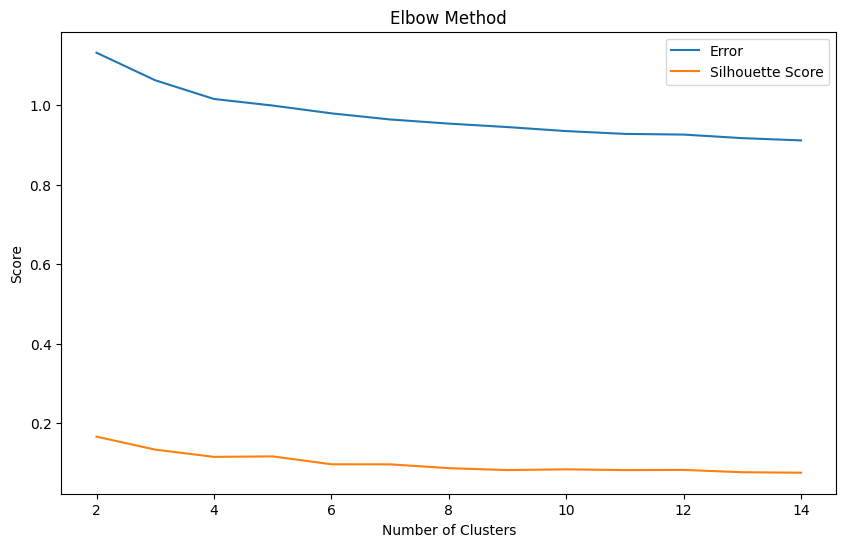

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

errors = []
silhouette_scores = []

for k in range(2, 15):
    som = KohonenSOM(input_dim, k, learning_rate)
    som.train(data_normalized.values, epochs=50)

    predictions = som.predict(data_normalized.values)
    error = np.mean([np.linalg.norm(data_normalized.values[i] - som.weights[predictions[i]]) for i in range(len(data_normalized))])
    errors.append(error)

    sil_score = silhouette_score(data_normalized, predictions)
    silhouette_scores.append(sil_score)

# График локтя
plt.figure(figsize=(10, 6))
plt.plot(range(2, 15), errors, label="Error")
plt.plot(range(2, 15), silhouette_scores, label="Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.title("Elbow Method")
plt.show()


In [ ]:
data['Cluster'] = clusters
cluster_summary = data.groupby('Cluster').mean()
print("Средние значения признаков для каждого кластера:")
print(cluster_summary)


Средние значения признаков для каждого кластера:
         TransactionID   AccountID  TransactionAmount  TransactionDate  \
Cluster                                                                  
0          1215.891566  262.465863         314.355703      1290.638554   
1          1169.193662  221.739437         286.623521      1256.746479   
2          1283.320423  259.742958         300.616690      1257.919014   
3          1317.224359  226.878205         273.141474       599.951923   
4          1359.208633  250.884892         339.051007      1247.525180   
5          1284.800000  232.400000         311.078304      1233.765217   
6          1146.894472  255.527638         278.474724      1413.653266   
7          1238.394984  253.956113         291.929028      1274.749216   
8          1266.484848  265.276094         284.626700      1839.858586   
9          1305.080402  239.693467         329.309447      1203.643216   

         TransactionType   Location    DeviceID  IP Address  M

**Ошибка восстановления (Error):**

Ошибка восстановления уменьшается с увеличением числа кластеров, что естественно, так как большее количество кластеров позволяет лучше описывать данные.
Однако снижение ошибки становится менее выраженным после 4–6 кластеров, что указывает на точку локтя.

**Силуэтный коэффициент (Silhouette Score):**

Значение силуэтного коэффициента наиболее высокое при небольшом количестве кластеров (около 3–4). После этого его значение снижается, что может указывать на уменьшение четкости кластеров.
Низкие значения силуэтного коэффициента при большем количестве кластеров могут свидетельствовать о том, что данные начинают перекрываться между кластерами или кластеры становятся слишком малыми.

**Оптимальное количество кластеров:**

На основе метода локтя (где ошибка перестает значительно снижаться) и анализа силуэтного коэффициента можно предположить, что оптимальное количество кластеров — 4 или 5.
Это количество дает баланс между качеством кластеризации и интерпретируемостью кластеров.

**Попробуем применить улучшения:**
1. Нормализуем данные, убираем выбросы и применяем стандартизацию.
2. Обучение SOM с увеличением числа нейронов
Увеличим количество нейронов для лучшего разделения данных.
3. Добавление радиуса соседства
Реализуем обучение SOM с радиусом соседства.
4. Снижение размерности данных с помощью PCA
Применяем PCA для выделения главных компонентов, чтобы лучше понять данные.
5. Оценка методом локтя и силуэтного коэффициента
Сравним результаты обычного SOM и улучшенного (с радиусом соседства).
6. Сравнение SOM и улучшенного SOM
Сравним силуэтный коэффициент для стандартного и улучшенного подхода
7. Интерпретация кластеров
Выведем средние значения признаков для каждого кластера.

In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# Нормализация и удаление выбросов
z_scores = np.abs(zscore(data))
data_filtered = data[(z_scores < 3).all(axis=1)]  # Убираем выбросы

# Стандартизация данных
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data_filtered)


In [ ]:
output_neurons = 20  # Увеличиваем число кластеров
learning_rate = 0.7  # Более высокая начальная константа обучения

# Создаем SOM
som = KohonenSOM(input_dim=data_standardized.shape[1], output_neurons=output_neurons, learning_rate=learning_rate)
som.train(data_standardized, epochs=200)  # Увеличиваем число эпох
clusters = som.predict(data_standardized)


In [ ]:
class KohonenSOMWithNeighborhood:
    def __init__(self, input_dim, output_neurons, learning_rate, neighborhood_radius):
        self.weights = np.random.rand(output_neurons, input_dim)
        self.weights = self.weights / np.linalg.norm(self.weights, axis=1, keepdims=True)
        self.learning_rate = learning_rate
        self.neighborhood_radius = neighborhood_radius

    def train(self, data, epochs):
        for epoch in range(epochs):
            for sample in data:
                distances = np.linalg.norm(self.weights - sample, axis=1)
                winner_index = np.argmin(distances)
                for i in range(len(self.weights)):
                    if np.abs(i - winner_index) <= self.neighborhood_radius:
                        self.weights[i] += self.learning_rate * (sample - self.weights[i])
            self.learning_rate *= 0.9
            self.neighborhood_radius = max(1, self.neighborhood_radius - 1)

    def predict(self, data):
        return np.argmin(np.linalg.norm(self.weights - data[:, None], axis=2), axis=1)

# Создаем SOM с радиусом соседства
som_with_neighborhood = KohonenSOMWithNeighborhood(
    input_dim=data_standardized.shape[1],
    output_neurons=20,
    learning_rate=0.7,
    neighborhood_radius=5
)
som_with_neighborhood.train(data_standardized, epochs=200)
clusters_with_neighborhood = som_with_neighborhood.predict(data_standardized)


In [ ]:
from sklearn.decomposition import PCA

# Снижаем размерность данных
pca = PCA(n_components=5)  # Снижаем до 5 главных компонентов
data_pca = pca.fit_transform(data_standardized)


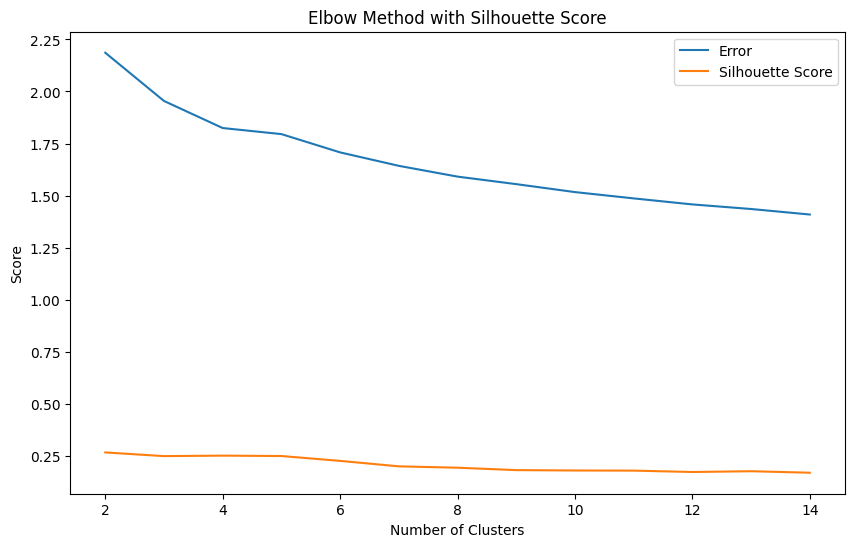

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

errors = []
silhouette_scores = []

# Оптимальное число кластеров
for k in range(2, 15):
    som = KohonenSOM(input_dim=data_pca.shape[1], output_neurons=k, learning_rate=0.5)
    som.train(data_pca, epochs=50)
    predictions = som.predict(data_pca)

    # Вычисляем ошибку и силуэтный коэффициент
    error = np.mean([np.linalg.norm(data_pca[i] - som.weights[predictions[i]]) for i in range(len(data_pca))])
    sil_score = silhouette_score(data_pca, predictions)

    errors.append(error)
    silhouette_scores.append(sil_score)

# График
plt.figure(figsize=(10, 6))
plt.plot(range(2, 15), errors, label="Error")
plt.plot(range(2, 15), silhouette_scores, label="Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.title("Elbow Method with Silhouette Score")
plt.show()


In [ ]:
# Силуэтный коэффициент для стандартного SOM
sil_score_standard = silhouette_score(data_pca, clusters)
print(f"Silhouette Score (Standard SOM): {sil_score_standard:.4f}")

# Силуэтный коэффициент для SOM с радиусом соседства
sil_score_neighborhood = silhouette_score(data_pca, clusters_with_neighborhood)
print(f"Silhouette Score (SOM with Neighborhood): {sil_score_neighborhood:.4f}")


Silhouette Score (Standard SOM): 0.0318
Silhouette Score (SOM with Neighborhood): 0.0333


In [ ]:
# Добавляем кластеры в данные
data_filtered['Cluster'] = clusters_with_neighborhood

# Средние значения признаков по кластерам
cluster_summary = data_filtered.groupby('Cluster').mean()
print("Средние значения признаков для каждого кластера:")
print(cluster_summary)


Средние значения признаков для каждого кластера:
         TransactionID   AccountID  TransactionAmount  TransactionDate  \
Cluster                                                                  
0          1405.148148   92.190476         268.582593      1218.169312   
1          1297.685185  264.240741         241.513056      1328.453704   
2          1116.087432  402.081967         285.806667      1237.322404   
3          1169.800000  391.000000         485.779250      1166.525000   
4          1497.216981  192.094340         311.418774      1252.301887   
5          1274.640625  204.281250         266.441016      1392.226562   
6          1155.209459  251.459459         270.306824      1315.398649   
7          1181.532110  267.009174         279.975596      1224.990826   
8          1281.357143  275.877551         297.972857       975.469388   
9          1383.337748  229.582781         213.066225       556.251656   
10         1407.103704  209.244444         233.217111       558

<ipython-input-29-8b2214a0b224>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Cluster'] = clusters_with_neighborhood
